## Text classification

I am performing test classification to identify labels as spam or not spam (ham)

In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

np.random.seed(36)


To keep track of different roc curves, I am creating a few lists to store them
tprs = []
fprs = []
roc_labels = []


### Data
We have a new data set in `data/spam_ham.csv`. Let's take a look at what it contains.

In [2]:
!head -2 spam_ham.csv

text,spam
'Hi...I have to use R to find out the 90\% confidence-interval for the sensitivityand specificity of the following diagnostic test:A particular diagnostic test for multiple sclerosis was conducted on 20 MSpatients and 20 healthy subjects, 6 MS patients were classified as healthyand 8 healthy subjects were classified as suffering from the MS.Furthermore, I need to find the number of MS patients required for asensitivity of 1\%...Is there a simple R-command which can do that for me?I am completely new to R...Help please!Jochen-- View this message in context: http://www.nabble.com/Confidence-Intervals....-help...-tf3544217.html#a9894014Sent from the R help mailing list archive at Nabble.com.______________________________________________R-help@stat.math.ethz.ch mailing listhttps://stat.ethz.ch/mailman/listinfo/r-helpPLEASE do read the posting guide http://www.R-project.org/posting-guide.html',ham


Looks like we have two features: some text (looks like an email), and a label for spam or ham. What is the distribution of the target variable?

In [3]:
!cut -f2 -d',' spam_ham.csv | sort | uniq -c | head

   1 
   1                  Alonzo Houser
   1                  Andrea Winslow
   1                  Arron Tanner
   1                  Becky Conklin
   1                  Christie Slaughter
   1                  Danial Good
   1                  Darcy Berger
   1                  Dena Major
   1                  Donna Henderson


This is not what I expected. 

As the data in the file is **text data**, it can actually have commas.
The command line will have some issues reading this data since it will try to split on all instances of the delimeter. Ideally, there should be a way of **encapsulating** the first column. As the first column is wrapped in single quotes. Python (and pandas) I can deal this with:

In [4]:
data = pd.read_csv("spam_ham.csv", quotechar="'", escapechar="\\")

Here I am specifying that fields that need to be encapsulated are done so with single quotes (`quotechar`). 

However, sometimes the text in a field can use single quotes. For example, apostrophes in words like "can't" would break the encapsulation. To overcome this, I **escape** single quotes that are actually just text. Here, I specified the escape character as a backslash (`escapechar`) (default prefix for quotechar). So now, for example, "can't" would be written as "can\'t" (need double backslash for literal slash).

Let's take another look at our data.

In [5]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham
2,Stephen Thorne wrote:> What I was thinking was...,ham
3,"Hi,I have this site that auto generates an ind...",ham
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,ham


Here, the target is whether or not a record should be considered as spam. This is recorded as the string 'spam' or 'ham'. To make it a little easier for the classifier, I will recode it as `0` or `1`.

In [6]:
data['spam'] = pd.Series(data['spam'] == 'spam', dtype=int)

In [7]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,0
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",0
2,Stephen Thorne wrote:> What I was thinking was...,0
3,"Hi,I have this site that auto generates an ind...",0
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,0


Split our data into a training and test set

In [8]:
X = data['text']
Y = data['spam']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

### Text as features
To turn the large amount of text for each record into useful features, I am using binary representation


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. In sklearn, I can do this with a `CountVectorizer()` and setting `binary` to `true`.  This will figure out what words exist in data.

In [9]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [10]:
list(binary_vectorizer.vocabulary_.keys())[0:10]

['canadianpharmacy',
 'is',
 'canadian',
 'online',
 'drugstore',
 'which',
 'has',
 'attractive',
 'and',
 'affordable']

Now that I know what words are in the data, I can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. I am doing this for the training and test data. 

In [11]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [12]:
X_test_binary

<2028x71157 sparse matrix of type '<class 'numpy.int64'>'
	with 225416 stored elements in Compressed Sparse Row format>

The output shows that the data is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140m cells that should have values. However, from the above, there are only ~220k cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. To begin with, I am looking at a smaller chunk.

In [13]:
X_test_binary[0:20, 0:20].todense() #full version

matrix([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0,

#### Applying a model
There are tons of features (as there are lots of words). Starting with logistic regression model to predict spam/ham.

In [14]:
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_binary), Y_test))

Area under the ROC curve on the test data = 0.996


Calculating ROC measure in more detail by looking at the actual ROC curve..

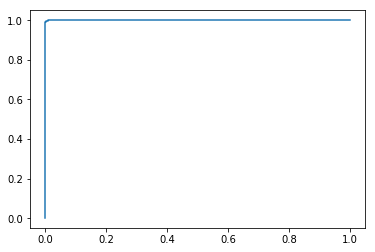

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Binary")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")


#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [15]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_counts, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test))

Area under the ROC curve on the test data = 0.995


Looking at the ROC curve...

Text(0.5,1,'ROC Curve')

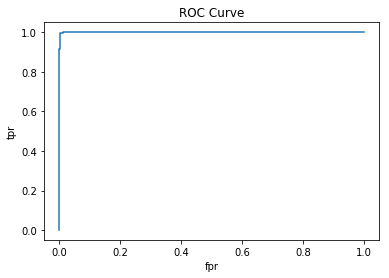

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Counts")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")


#### Tf-idf
Using another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure.

In [18]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test))

Area under the ROC curve on the test data = 0.986


Once again, looking at the ROC curve

Text(0.5,1,'ROC Curve')

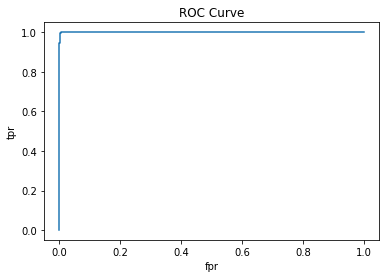

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Tfidf")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")


Now that we have a few different feature sets and models, let's look at all of our ROC curves.

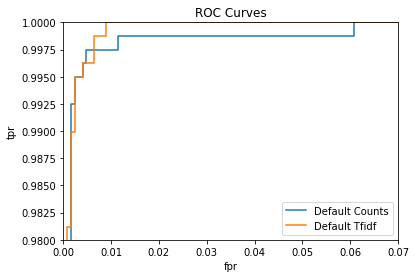

In [20]:
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, .07])
plt.ylim([.98, 1])
plt.show()

### Naive Bayes
Using (Bernoulli) naive Bayes classifier for text classification



In [26]:
model = BernoulliNB()
model.fit(X_train_tfidf, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [27]:
print("AUC on the count data = %.3f" % metrics.roc_auc_score(model.predict(X_test_tfidf), Y_test))

AUC on the count data = 0.976
